In [1]:
import numpy as np
import matplotlib.patches as mpatches
import copy
import torch.utils.data
import json

import pylab as plt
plt.rc('text', usetex=True)
plt.rc('font', size=20,family='serif')
# plt.style.use('matplotlibrc')
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter

%matplotlib inline

# Look at traces from "Cryo-EM structure of the insect olfactory receptor Orco", Butterwick et al. 2018

In [2]:
import pandas as pd

In [3]:
# data from Butterwick et al. 2018
df_cryoEM = pd.read_csv('20170717_cell4.csv', sep='\t')
df_cryoEM.set_index('time (s)',inplace=True)

# we subtract the baseline leak current
# by taking the average about period from 20-40s (no ligand present)
df_cryoEM -= df_cryoEM['20':'40'].mean()

# we also define two parts of the signal we are especially interested in:
# from 48.9s - 49.6s where the ligand is binding, and a single Orco opens (see below)
df_cryoEM_data = df_cryoEM['48.9':'49.6']
df_cryoEM_data.index = df_cryoEM_data.index - 48.9
# from 20s - 40s where there is only noise
df_cryoEM_noise = df_cryoEM['20':'40']
df_cryoEM_noise.index = df_cryoEM_noise.index - 20

In [4]:
df_cryoEM

,current (pA)
time (s),
0.00000,0.295841
0.00005,0.112741
0.00010,0.204291
0.00015,0.387401
0.00020,0.448431
...,...
78.68120,0.204291
78.68125,-0.283989
78.68130,-0.406059


Let's plot the data (in grey: odor is presented)

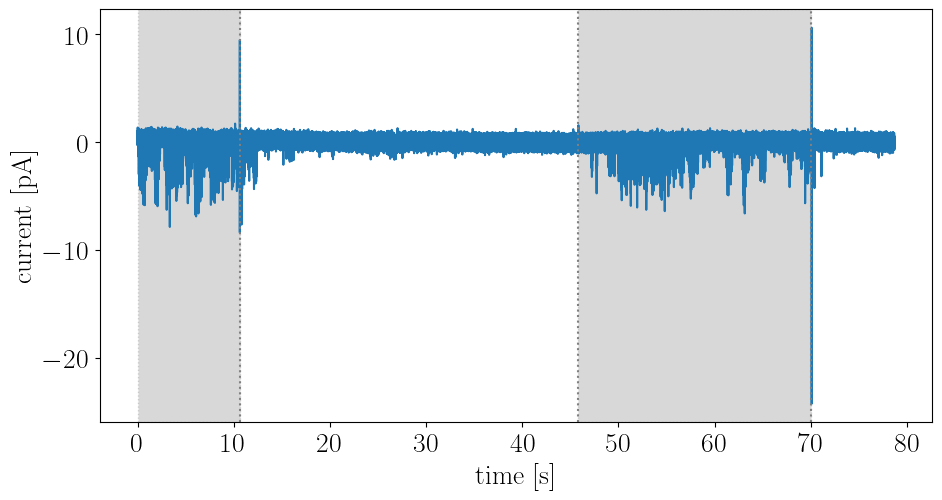

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(2*5.37, 5.37))
plt.rcParams['figure.dpi'] = 150

# df.plot(x='time (s)', y='current (pA)')
plt.plot(df_cryoEM.index, df_cryoEM)
# plt.legend()

# plt.xlim(0, 130)
# plt.ylim(-10, 10)

ax.set(xlabel='time [s]', ylabel='current [pA]')

plt.axvline(x=10.6, color='gray', linestyle='dotted')
plt.axvline(x=45.8, color='gray', linestyle='dotted')
plt.axvline(x=70.0, color='gray', linestyle='dotted')
plt.axvspan(0, 10.6, color='gray', linestyle='dotted', alpha=0.3)
plt.axvspan(45.8, 70.0, color='gray', linestyle='dotted', alpha=0.3)

plt.show()

Let's zoom in into the part shown in the paper (Extended Data Fig. 2 c):

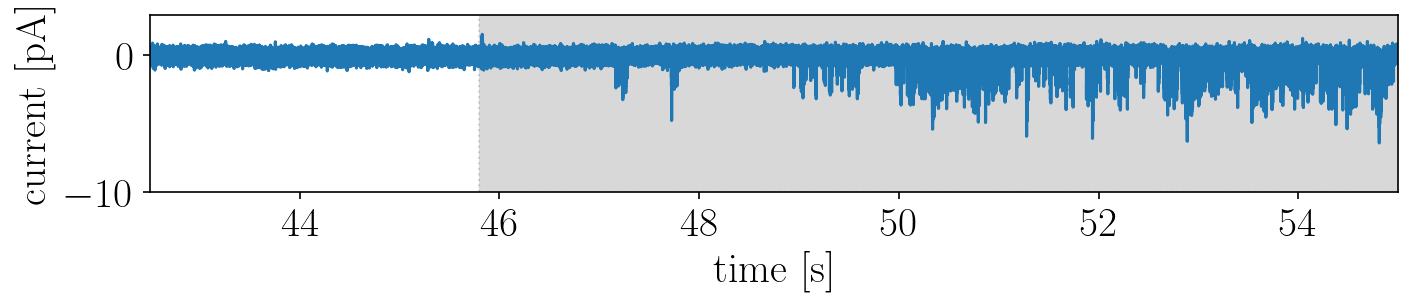

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(2*5.37, 5.37/3.5))
plt.rcParams['figure.dpi'] = 150

# df.plot(x='time (s)', y='current (pA)')
plt.plot(df_cryoEM.index, df_cryoEM)
# plt.legend()

plt.xlim(42.5, 55.0)
# plt.xlim(42, 79)
plt.ylim(-10, 3)

ax.set(xlabel='time [s]', ylabel='current [pA]')

plt.axvspan(0, 10.6, color='gray', linestyle='dotted', alpha=0.3)
plt.axvspan(45.8, 70.0, color='gray', linestyle='dotted', alpha=0.3)

plt.show()

As we can see, the recording shows noise of O(<1 pA), some signal (e.g. at around 49.5s) which is O(1 pA), and then larger signal (e.g. starting at 50s). The former can be attributed to a single Orco opening/closing, while the latter may be caused by multiple Orcos being probed at the same time.

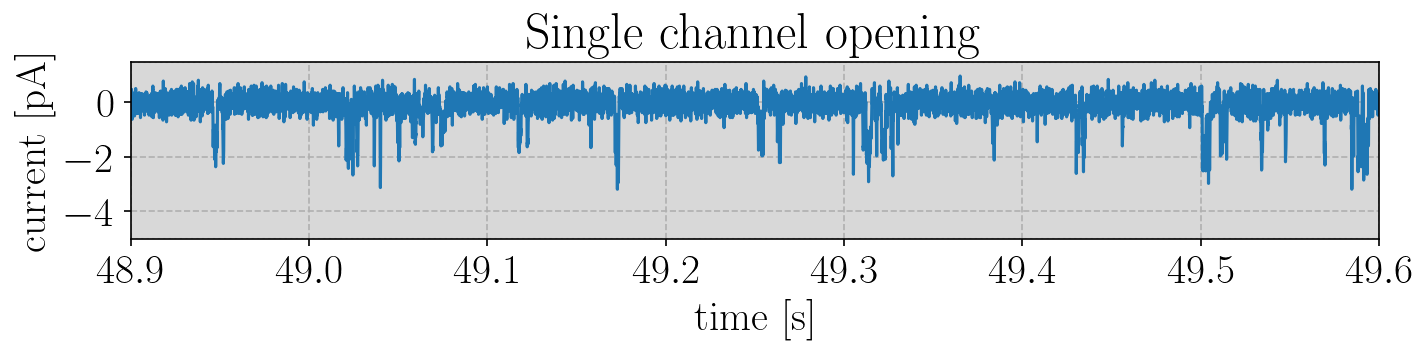

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(2*5.37, 5.37/3.5))
plt.rcParams['figure.dpi'] = 150

# df.plot(x='time (s)', y='current (pA)')
plt.plot(df_cryoEM.index, df_cryoEM)
# plt.legend()

plt.xlim(48.9, 49.6)
# plt.xlim(48, 79)
plt.ylim(-5, 1.5)
plt.locator_params(axis='y', nbins=4) 
plt.grid(linestyle="--")

ax.set(xlabel='time [s]', ylabel='current [pA]')

plt.title('Single channel opening')

# plt.axvspan(0, 10.6, color='gray', linestyle='dotted', alpha=0.3)
plt.axvspan(45.8, 70.0, color='gray', linestyle='dotted', alpha=0.3)

plt.show()

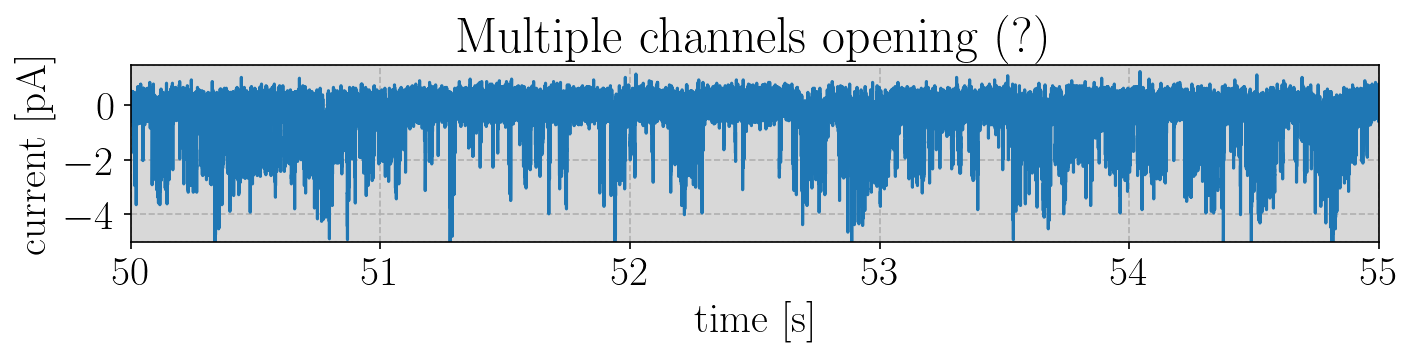

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(2*5.37, 5.37/3.5))
plt.rcParams['figure.dpi'] = 150

# df.plot(x='time (s)', y='current (pA)')
plt.plot(df_cryoEM.index, df_cryoEM)
# plt.legend()

# plt.xlim(48.9, 49.6)
plt.xlim(50, 55)
plt.ylim(-5, 1.5)
plt.locator_params(axis='y', nbins=4) 
plt.grid(linestyle="--")

plt.title('Multiple channels opening (?)')

ax.set(xlabel='time [s]', ylabel='current [pA]')

# plt.axvspan(0, 10.6, color='gray', linestyle='dotted', alpha=0.3)
plt.axvspan(45.8, 70.0, color='gray', linestyle='dotted', alpha=0.3)

plt.show()

Because we want to model individual Orco, we thus define as 'measured data' the part of the signal from [48.9,49.6]s.

# Modelling traces with a simple ORCO gate model

In [9]:
# Sampling step size in terms of sec
# Measurement by Butterwick et al. has dt=5e-5s, which we also use here
dt = 5e-5

# total number of steps in units of dt
# corresponds to 20.0s
total_steps = int(20.0 / dt)

# number of steps when odour is presented in units of dt
data_steps = int(20.0 / dt)

The signal is modelled as a stoachstic process with N ORCOs opening with probability p_open, closing with p_close. Units: x = sec, y = pA

Model parameters to change to model different ORCOs:

In [10]:
def p_open(k_on, conc_L, dt):
    """
        Probability density of ion channel opening
        k_on: binding rate of ligand per dt
        conc_L: ligand concentration
    """
    return k_on * conc_L

def ORCO_to_current(ORCO_states, conv_open_mean, conv_open_stdev, conv_closed_mean, conv_closed_stdev):
    """
        Converts the open/closed states to currents
        conv_mean: mean for closed/open current e.g. from Butterwick et al.
        conv_stdev: std dev for closed/open current
    """
    curr = ORCO_states.astype('float')
    curr[curr == 1] = np.random.normal(conv_open_mean, conv_open_stdev, size=curr[curr == 1].shape)
    curr[curr == 0] = np.random.normal(conv_closed_mean, conv_closed_stdev, size=curr[curr == 0].shape)
    return curr
    

def p_close(k_off, dt):
    """
        Probability density of ion channel closing
        k_off: unbinding rate of ligand per dt
    """
    return k_off

def calc_ORCO_state(curr_state, k_on, k_off, conc_L, dt):
    """
        Returns updated state of single ORCO
        0: ORCO closed
        1: ORCO open
    """
    rand = np.random.random()
    if curr_state == 0:
        if rand < p_open(k_on, conc_L, dt):
            return 1
        else:
            return 0
    elif curr_state == 1:
        if rand < p_close(k_off, dt):
            return 0
        else:
            return 1

Before performing our ORCO state simulation, we need to estimate the transition probabilities p_open and p_close.
We do this by binning the recorded data into two states, and calculating the probability per dt of opening/closing states

In [11]:
# we take two bins, split at -0.75 pA. Values are inverted here because we want the '0' bin to mean 'closed'
df_cryoEM_data_binary = pd.cut(-df_cryoEM_data.iloc[:,0], [-100, 0.75, 100], labels = False)
X = df_cryoEM_data_binary.values

# generate a matrix of all transitions and normalize to get probability
transition_matrix = pd.crosstab(
    pd.Series(X[:-1], name='from'),
    pd.Series(X[1:], name='to'),
    normalize=0
)

transition_matrix

to,0,1
from,,
0,0.992945,0.007055
1,0.095933,0.904067


Simulation:

In [12]:
# Parameters for Markov state transition
k_off = transition_matrix.iloc[1,0]
print("k_off", k_off)
k_on = transition_matrix.iloc[0,1]
print("k_on", k_on)
conc_L = 1.0

# ORCO to current conversion, see Butterwick et al. 2018 Extended Data Fig. 2d
conv_open_mean, conv_open_stdev = -1.5, 0.6
conv_closed_mean, conv_closed_stdev = 0.0, 0.3

k_off 0.09593326381647549
k_on 0.007054673721340388


In [13]:
# evolve binding and unbinding for a single ion channel

ORCO_states = np.zeros(data_steps) # start in unbound state
for i, _ in enumerate(ORCO_states[:-1]):
    ORCO_states[i+1] = calc_ORCO_state(ORCO_states[i], k_on, k_off, conc_L, dt)
    
# calculate current
clean_current = ORCO_to_current(ORCO_states, conv_open_mean, conv_open_stdev, conv_closed_mean, conv_closed_stdev)

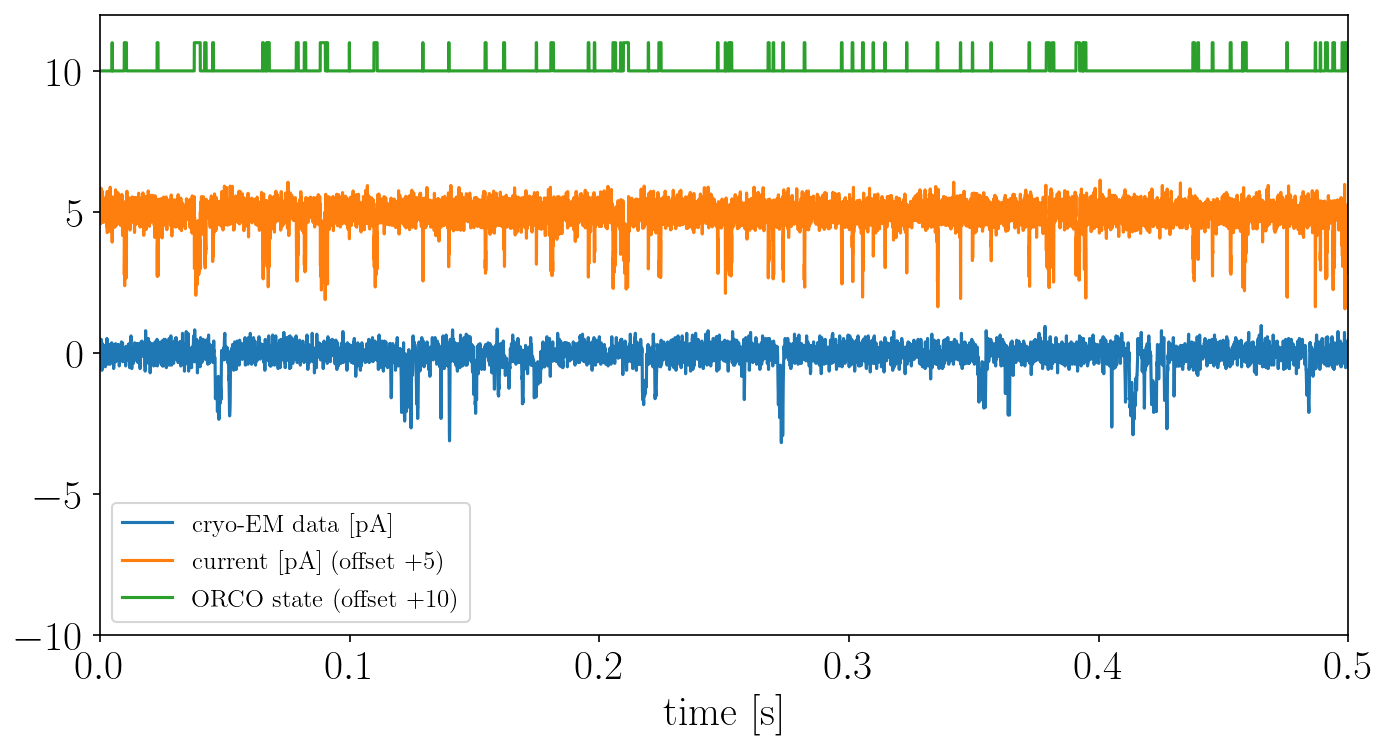

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(2*5.37, 5.37))
plt.rcParams['figure.dpi'] = 150

plt.xlim(0, 0.5)
plt.ylim(-10, 12)

x_range = np.linspace(0,len(df_cryoEM_data)*dt,len(df_cryoEM_data))
plt.plot(df_cryoEM_data, label = 'cryo-EM data [pA]')

x_range = np.linspace(0,len(ORCO_states)*dt,len(ORCO_states))
plt.plot(x_range, clean_current + 5, label = 'current [pA] (offset +5)')
plt.plot(x_range, ORCO_states + 10, label = 'ORCO state (offset +10)')

ax.set(xlabel='time [s]')

plt.legend(prop={'size': 12})

plt.show()

We now look at the histogram to see if it matches Butterwick et al.
As we can see, the peaks positions and widths match nicely, but the overall scaling of the 'open' and 'closed' bins is off.
This is most likely due to ligand concentration fluctuations, and will be covered later by the 'noise only' simulation phase, which widens the 'closed' state.

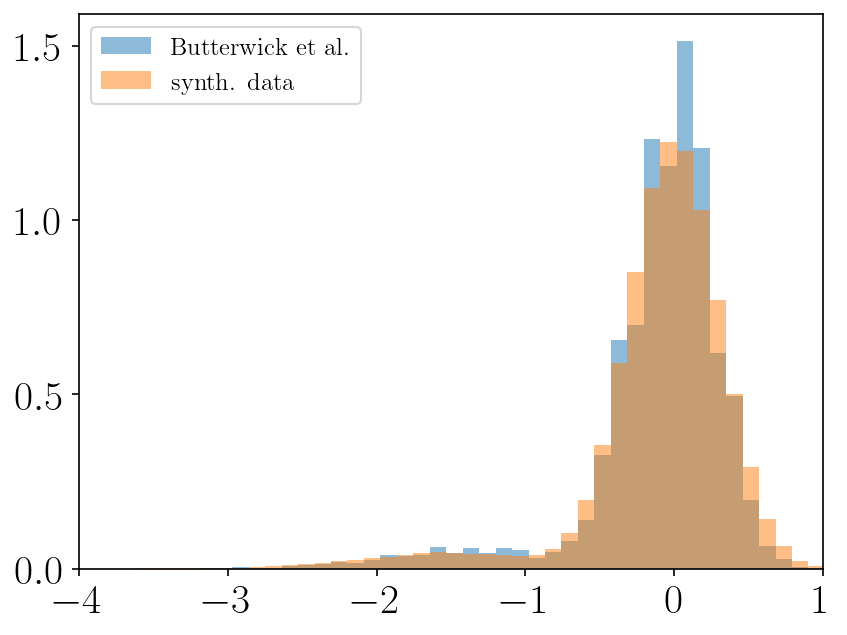

In [15]:
bins = np.histogram(np.hstack((df_cryoEM_data.values.ravel(),clean_current)), bins=50, density=True)[1]
plt.hist(df_cryoEM_data, bins=bins, alpha=0.5, label='Butterwick et al.', density=True)
plt.hist(clean_current, bins=bins, alpha=0.5, label='synth. data', density=True)
plt.xlim(-4, 1)
# plt.xlim(0.0, 0.1)
plt.legend(prop={'size': 12})
plt.show()

# Add baseline noise

We need to model the noise in the ion channel opening/closing and recording. Fortunately, the recordings by Butterwick et al. have parts without ligand present (e.g. from 20s to 40s).

In [16]:
# noise of ion channel
noise_mu = 0.0
noise_sigma = 0.5

In [17]:
noise = np.random.normal(noise_mu, noise_sigma, size=ORCO_states.shape)

We apply a low-pass filter to the noise in order to fit (by eye) the PSD of the measurement

In [18]:
from scipy import signal
from scipy.signal import butter,filtfilt

In [19]:
# Filter requirements.
fs = 100.0       # sample rate, Hz
cutoff = 20      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hznyq = 0.5 * fs  # Nyquist Frequencyorder = 2       # sin wave can be approx represented as quadratic
nyq = 0.5 * fs  # Nyquist Frequency

In [20]:
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [21]:
# apply low-pass filter
noise_LPF = butter_lowpass_filter(noise, cutoff, fs, order=1)

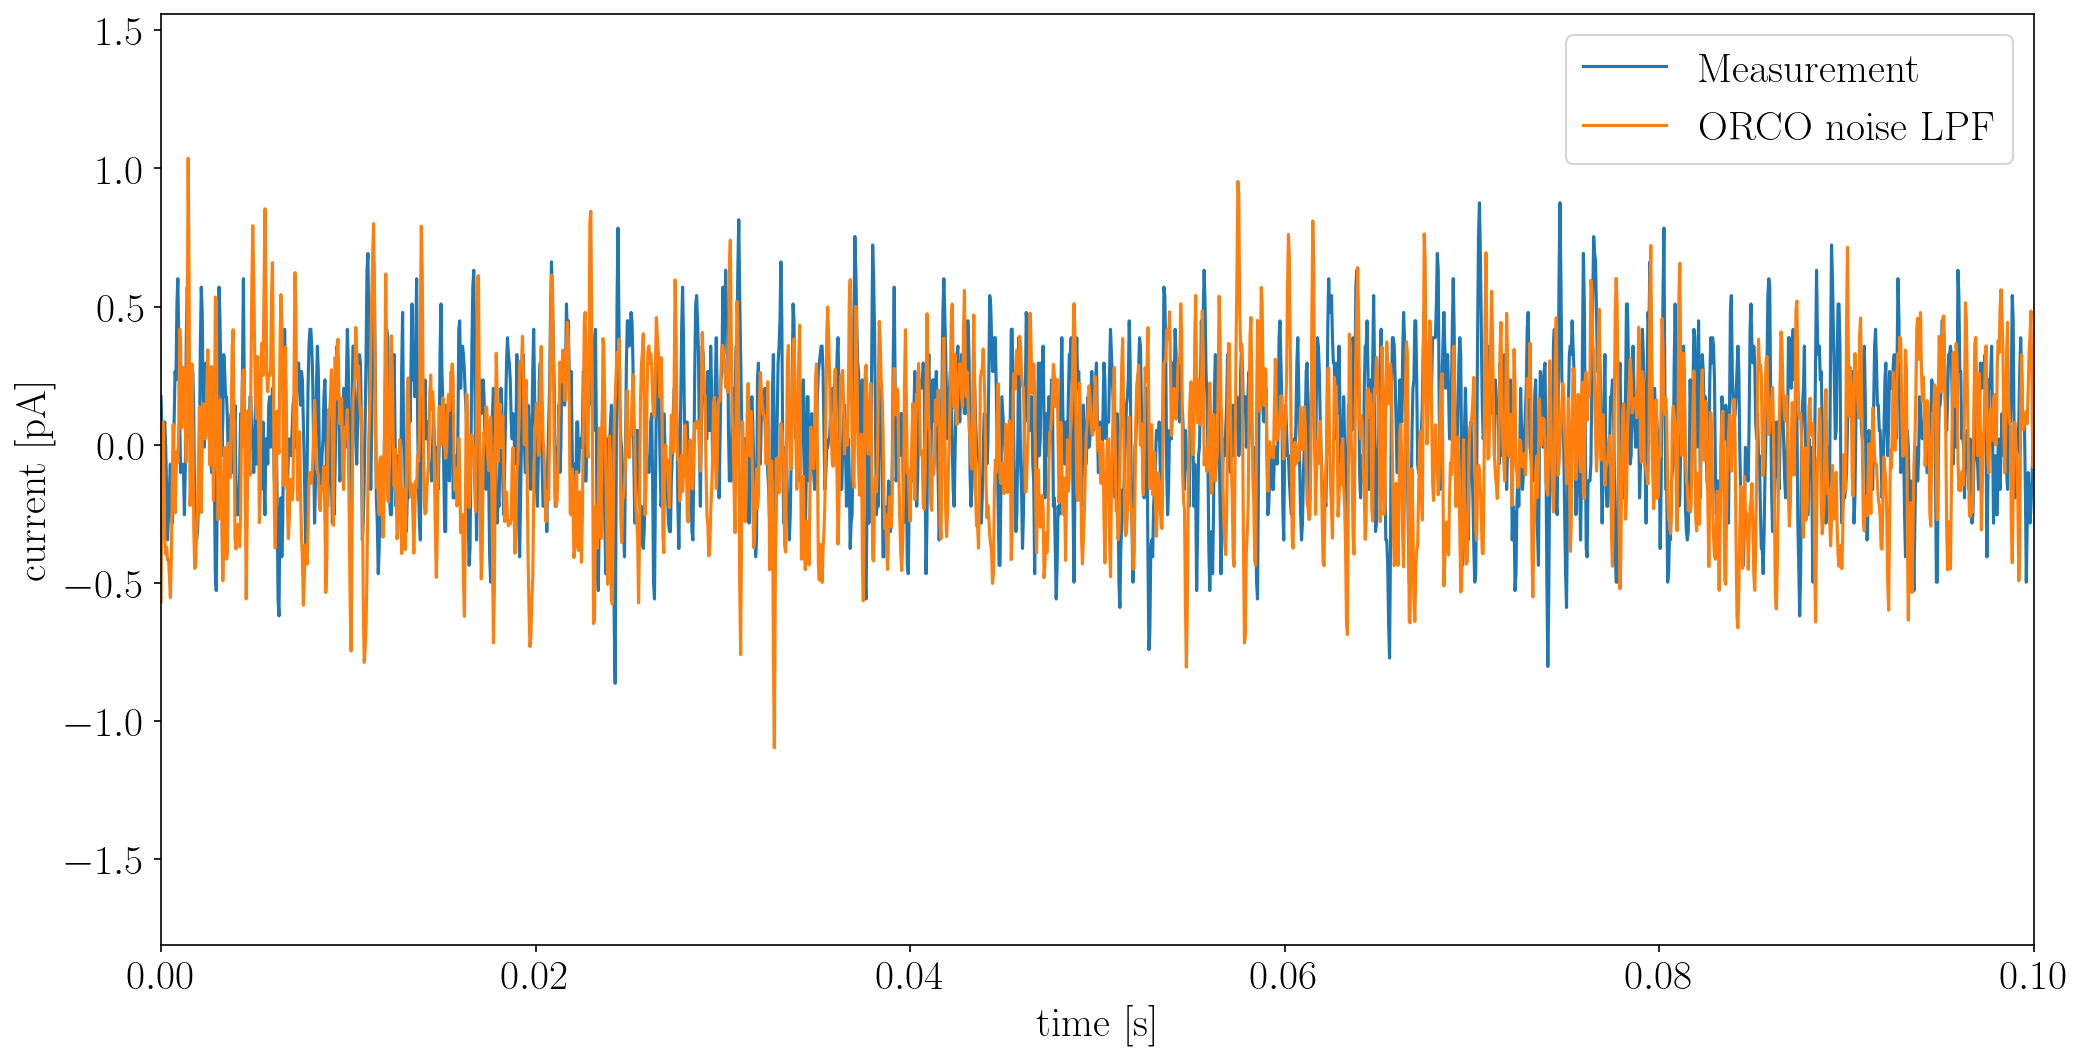

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(3*5.37, 1.5*5.37))

plt.plot(df_cryoEM_noise, label="Measurement")

# convert sample length to seconds
x_range = np.linspace(0,len(noise_LPF)*dt,len(noise_LPF))

# plt.plot(x_range, ORCO_states, label="ORCO")
plt.plot(x_range, noise_LPF, label="ORCO noise LPF")

plt.xlim(0.0, 0.1)
# plt.ylim(-1.0, 1.0)

ax.set(xlabel='time [s]', ylabel='current [pA]')

plt.legend()

plt.show()

## Spectral analysis

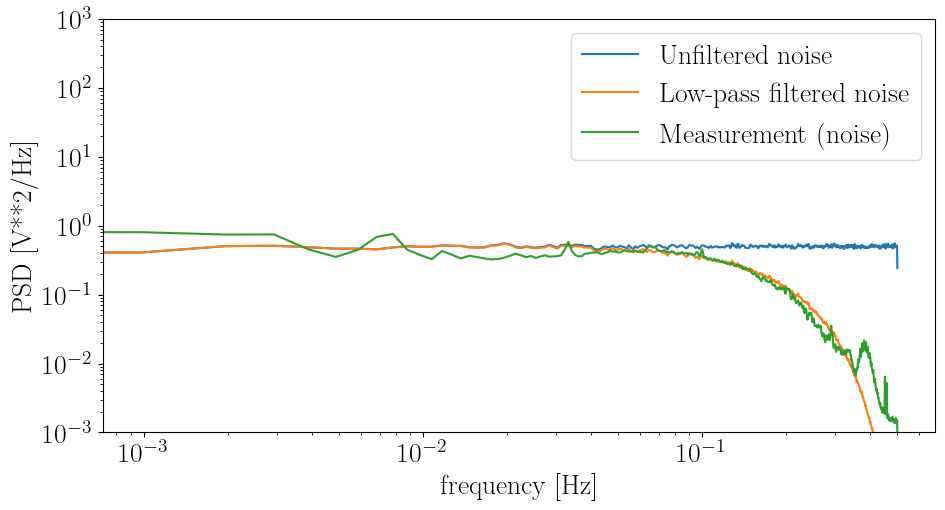

In [23]:
plt.rcParams['figure.dpi'] = 100

fig, ax = plt.subplots(1, 1, figsize=(2*5.37, 5.37))
plt.rcParams['figure.dpi'] = 150

f, Pxx_den = signal.welch(noise, nperseg=1024)
plt.loglog(f, Pxx_den, label='Unfiltered noise')

f, Pxx_den = signal.welch(noise_LPF, nperseg=1024)
plt.loglog(f, Pxx_den, label='Low-pass filtered noise')

f, Pxx_den = signal.welch(df_cryoEM_noise.iloc[:,0], nperseg=1024)
plt.loglog(f, Pxx_den, label='Measurement (noise)')


plt.ylim([1e-3, 1e+3])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')

plt.legend()

plt.show()

# ORCO current

Let's add the noise to the ORCO current:

In [24]:
current = clean_current + noise_LPF

Let's look at a particular region in the measurement (50s -- 70s) with high activity and compare to our synthetic data:

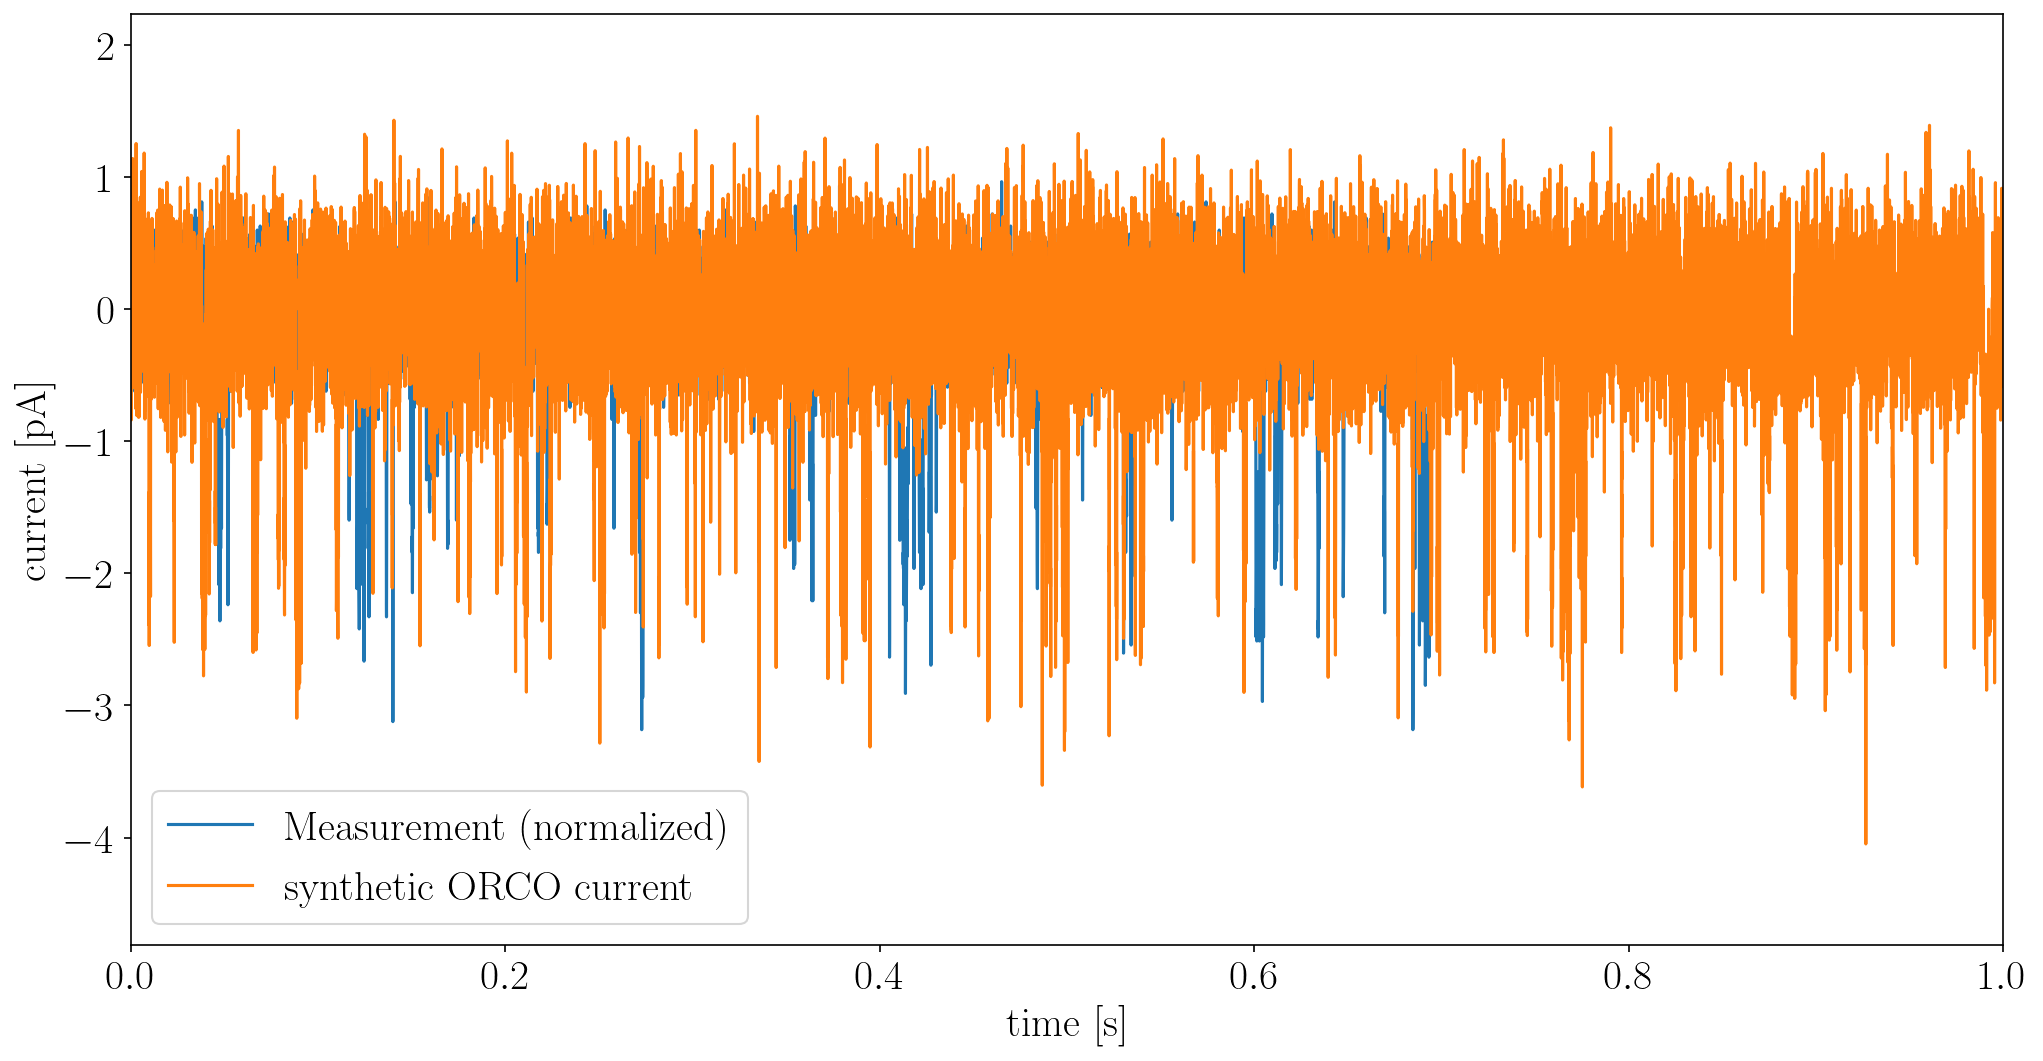

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(3*5.37, 1.5*5.37))
plt.rcParams['figure.dpi'] = 100

plt.plot(df_cryoEM_data, label="Measurement (normalized)")

# convert sample length to seconds
x_range = np.linspace(0,len(ORCO_states)*dt,len(ORCO_states))
plt.plot(x_range, current, label="synthetic ORCO current")

# plt.plot(x_range, ORCO_to_CURRENT_conv * ORCO_states, label="clean ORCO")
# plt.plot(x_range, noise_LPF, label="noise")

plt.xlim(0.0, 1.0)
# plt.ylim(-3.0, 1.0)

ax.set(xlabel='time [s]', ylabel='current [pA]')

plt.legend()

plt.show()

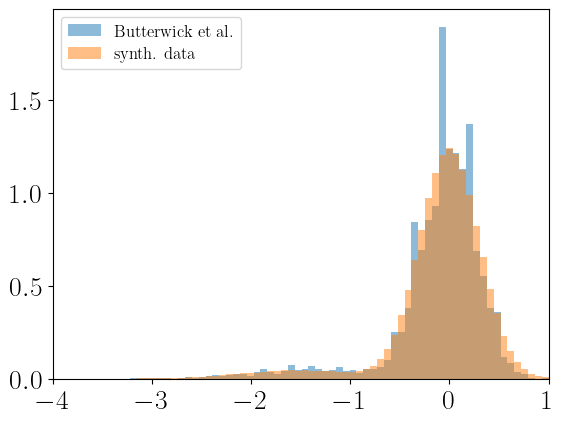

In [26]:
# looking at the histogram to see if it matches Butterwick et al.
bins = np.histogram(np.hstack((df_cryoEM_data.values.ravel(),clean_current)), bins=80, density=True)[1]
plt.hist(df_cryoEM_data, bins=bins, alpha=0.5, label='Butterwick et al.', density=True)
plt.hist(clean_current, bins=bins, alpha=0.5, label='synth. data', density=True)
plt.xlim(-4, 1)
# plt.xlim(0.0, 0.1)
plt.legend(prop={'size': 12})
plt.show()

## Spectral analysis

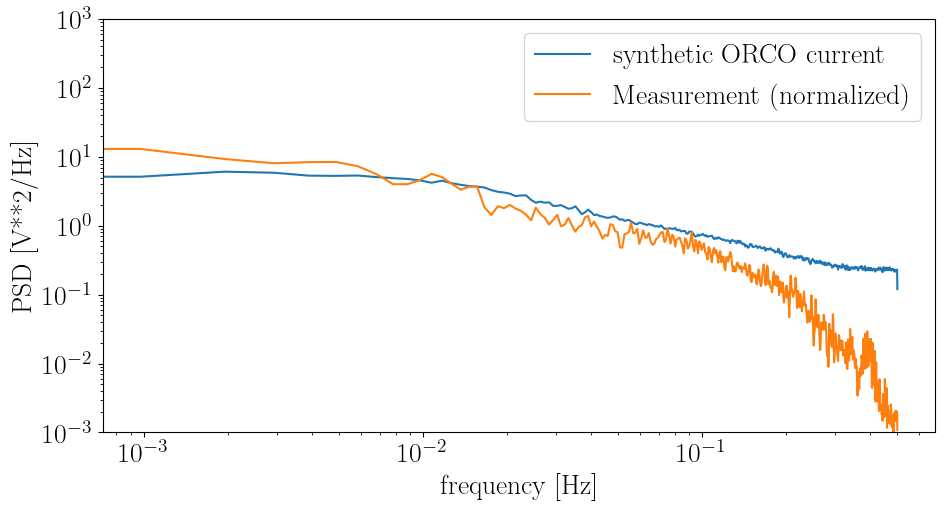

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(2*5.37, 5.37))
plt.rcParams['figure.dpi'] = 150

f, Pxx_den = signal.welch(current, nperseg=1024)
plt.loglog(f, Pxx_den, label='synthetic ORCO current')

f, Pxx_den = signal.welch(df_cryoEM_data.iloc[:,0], nperseg=1024)
plt.loglog(f, Pxx_den, label='Measurement (normalized)')


plt.ylim([1e-3, 1e+3])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')

plt.legend()

plt.show()

# Electrode response

The electrode in the pad will not measure single ORCOs. We therefore need to repeat the previous steps for N_ORCOS.

In [28]:
# number of ORCOs to simulate
N_ORCOS = 10

# noise of ion channel
noise_mu = 0.0
noise_sigma = 0.5

# Parameters for Markov state transition
k_off = 0.0966
k_on  = 0.0071
conc_L = 1.0

# ORCO to current conversion, see Butterwick et al. 2018 Extended Data Fig. 2d
conv_open_mean, conv_open_stdev = -1.5, 0.6
conv_closed_mean, conv_closed_stdev = 0.0, 0.3

In [29]:
# repeat all steps for N_ORCOS and sum

summed_current = []
for n in range(N_ORCOS):
    ORCO_states = np.zeros(data_steps) # start in unbound state
    for i, _ in enumerate(ORCO_states[:-1]):
        ORCO_states[i+1] = calc_ORCO_state(ORCO_states[i], k_on, k_off, conc_L, dt)

    # calculate current
    current_arr = ORCO_to_current(ORCO_states, conv_open_mean, conv_open_stdev, conv_closed_mean, conv_closed_stdev)
    
    noise_arr = np.random.normal(noise_mu, noise_sigma, size=current_arr.shape)
    current_arr += butter_lowpass_filter(noise_arr, cutoff, fs, order=1)
    
    summed_current.append(np.array(current_arr))
    
summed_current = np.sum(summed_current, axis=0)

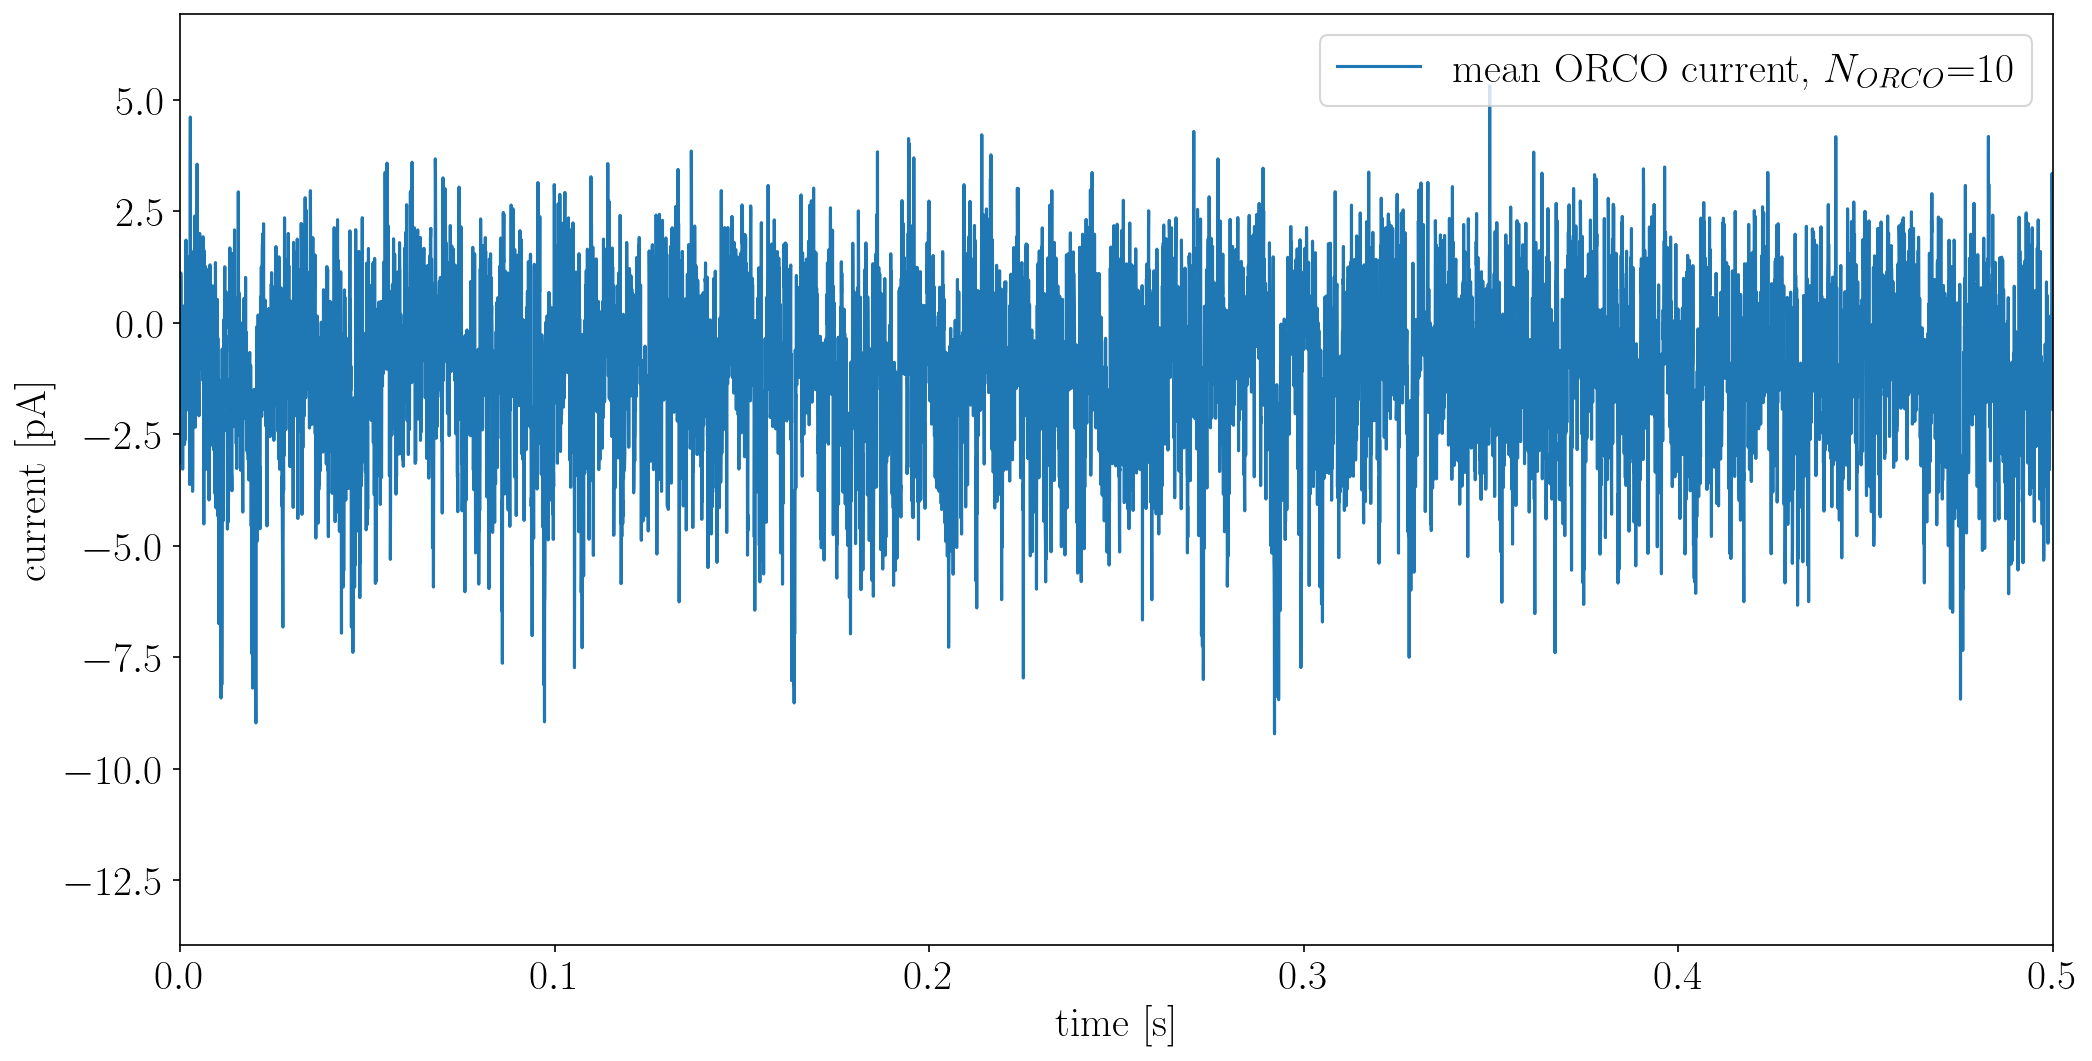

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(3*5.37, 1.5*5.37))
plt.rcParams['figure.dpi'] = 100

# convert sample length to seconds
x_range = np.linspace(0,len(summed_current)*dt,len(summed_current))
plt.plot(x_range, summed_current, label="mean ORCO current, $N_{ORCO}$=" + str(N_ORCOS))

plt.xlim(0.0, 0.5)
# plt.ylim(-3.0, 1.0)

ax.set(xlabel='time [s]', ylabel='current [pA]')

plt.legend(loc='upper right')

plt.show()

We now have the total current, but need to calculate the induced voltage in the electrode. This is a simple analogue low-pass filter (RC-circuit), which we parametrize using the circuit time constant tau and C (capacitance).

In [31]:
# conversion from current to voltage
R_gap = 6.37e+7 # Ohm

# capacitance of electrode circuit
C_dl = 8.99e-11 # F

# resistance of electrode circuit
R_t = 7.92e+8 # Ohm

# convert pA to A
pico_conversion_factor = 1e-12

# time constant of electrode circuit
# in units of seconds
tau = C_dl * R_t

In [32]:
# model electrode as low-pass filter

voltage = 0.0
voltage_arr = np.zeros(len(summed_current))
for i, _ in enumerate(summed_current[:-1]):
    input_current = summed_current[i]
    voltage += dt / tau * (- voltage + R_gap * input_current * pico_conversion_factor)
    voltage_arr[i+1] = voltage.copy()


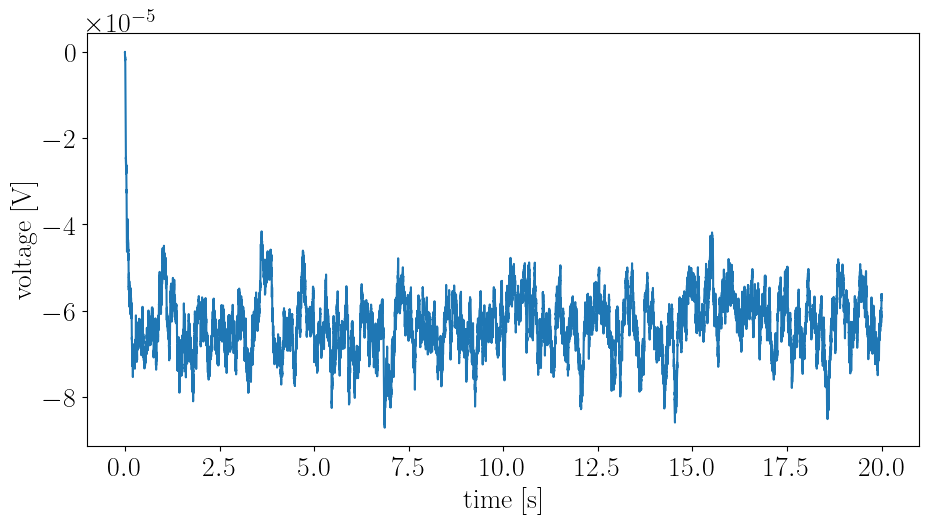

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(2*5.37, 5.37))
plt.rcParams['figure.dpi'] = 150

# convert sample length to seconds
x_range = np.linspace(0,len(voltage_arr)*dt,len(voltage_arr))
plt.plot(x_range, voltage_arr)

# plt.xlim(100, 200)
# plt.ylim(-10, 10)

ax.set(xlabel='time [s]', ylabel='voltage [V]')

# plt.legend()

plt.show()

# From single ORNs to different odorants

So far, we have modeled the generic response of a receptor/ORCO to a ligand. Now, we want to generate distributions of responses for a given odorant.
To do so, we use the data from the DoOR 2.0.1 dataset.

The procedure is simple: use the (normalized) spike rate from Hallem and Carlson as a proxy for the ligand concentration.

## Import data

In [34]:
receptor_labels = np.loadtxt("DoOR_datasets/receptor_labels.txt", dtype='str', delimiter=',')
odorant_labels = np.genfromtxt("DoOR_datasets/odorant_labels.txt", dtype='str', delimiter='\n')
# # For the DoOR datasets, the odorant labels are also provided by their InChIKey
# odorant_labels = np.loadtxt("DoOR_datasets/odorant_labels_InChIKey.txt", dtype='str', delimiter=',')
receptor_responses = np.loadtxt("DoOR_datasets/receptor_responses.csv", delimiter=',')
DoOR_normalized_receptor_responses = receptor_responses

# exclude all receptors which are not Or
Or_receptor_idx = np.where(np.char.find(receptor_labels, 'Or') == 0)[0]
receptor_labels = receptor_labels[Or_receptor_idx]
receptor_responses = receptor_responses[:,Or_receptor_idx]

In [35]:
receptor_labels

array(['Or1a', 'Or2a', 'Or7a', 'Or9a', 'Or10a', 'Or13a', 'Or19a', 'Or22a',
       'Or22b', 'Or22c', 'Or23a', 'Or24a', 'Or30a', 'Or33a', 'Or33b',
       'Or33c', 'Or35a', 'Or42a', 'Or42b', 'Or43a', 'Or43b', 'Or45a',
       'Or45b', 'Or46a', 'Or47a', 'Or47b', 'Or49a', 'Or49b', 'Or59a',
       'Or59b', 'Or59c', 'Or65a', 'Or67a', 'Or67b', 'Or67c', 'Or67d',
       'Or71a', 'Or74a', 'Or82a', 'Or85a', 'Or85b', 'Or85c', 'Or85d',
       'Or85e', 'Or85f', 'Or88a', 'Or92a', 'Or94a', 'Or94b', 'Or98a',
       'Or69a', 'Or83c'], dtype='<U11')

In [36]:
# odorant_labels

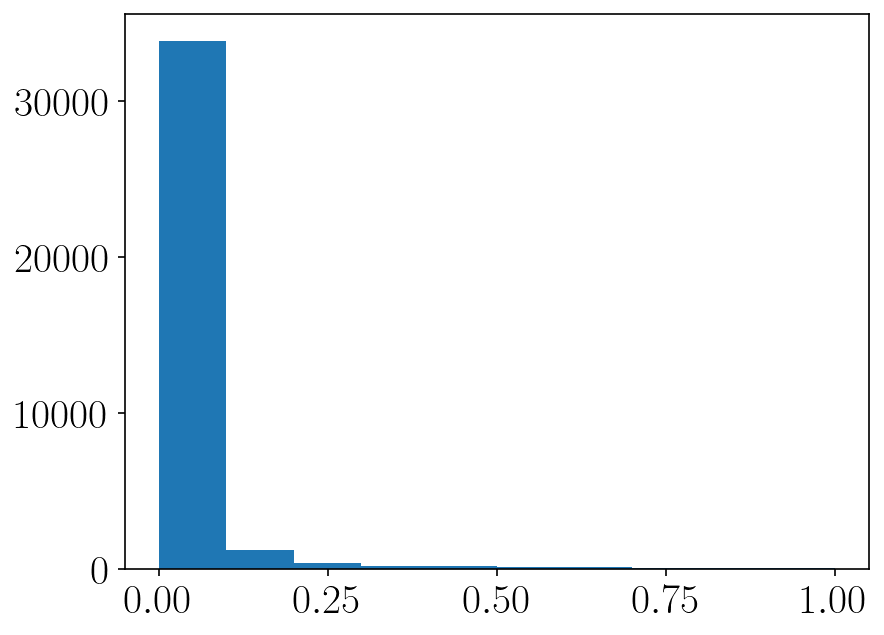

In [37]:
# look at the histogram
plt.hist(receptor_responses.ravel(), bins=10)
# plt.xlim(-3.5, 0.5)
plt.show()

## Generate ORN distributions

In [38]:
DoOR_normalized_receptor_responses

array([[0.06271442, 0.06972846, 0.05604998, ..., 0.02069475, 0.02045679,
        0.07834101],
       [0.02263735, 0.        , 0.08676553, ..., 0.02522173, 0.0227292 ,
        0.        ],
       [0.47684328, 0.        , 0.04964198, ..., 0.02295824, 0.02443393,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [39]:
data_steps = 10_000

In [40]:
# generate ORCO responses for 78 ORNs
N_ORN = len(receptor_labels)

# Let's pick 3 odorants
odorant_idx = [44,164,2]
N_ORCOS = 10
N_odorants = len(odorant_idx)
selected_receptor_responses = DoOR_normalized_receptor_responses[odorant_idx]
selected_odorant_labels = odorant_labels[odorant_idx]

odorant_ORN_voltages = []

for receptor_responses in selected_receptor_responses:
    ORN_currents = []
    
    for OR_id in range(N_ORN):
        summed_current = []
        for n in range(N_ORCOS):
            ORCO_states = np.zeros(data_steps) # start in unbound state
            for i in range(data_steps-1):
                ORCO_states[i+1] = calc_ORCO_state(ORCO_states[i], k_on, k_off, receptor_responses[OR_id], dt)

            # calculate current
            current_arr = ORCO_to_current(ORCO_states, conv_open_mean, conv_open_stdev, conv_closed_mean, conv_closed_stdev)

            noise_arr = np.random.normal(noise_mu, noise_sigma, size=current_arr.shape)
            current_arr += butter_lowpass_filter(noise_arr, cutoff, fs, order=1)

            summed_current.append(np.array(current_arr))

        summed_current = np.sum(summed_current, axis=0)
        ORN_currents.append(summed_current)
        
    ORN_voltages = []
    # model electrode as low-pass filter
    for current in ORN_currents:
        # convert pA current to voltage in Volt
        voltage = 0.0
        voltage_arr = np.zeros(len(current))
        for i, _ in enumerate(current[:-1]):
            input_current = current[i]
            voltage += dt / tau * (- voltage + R_gap * input_current * pico_conversion_factor)
            voltage_arr[i+1] = voltage.copy()
        ORN_voltages.append(voltage_arr)
        
    odorant_ORN_voltages.append(ORN_voltages)
    
odorant_ORN_voltages = np.array(odorant_ORN_voltages)

In [41]:
# odorant_ORN_currents should have shape odorants x receptors x time steps
odorant_ORN_voltages.shape

(3, 52, 10000)

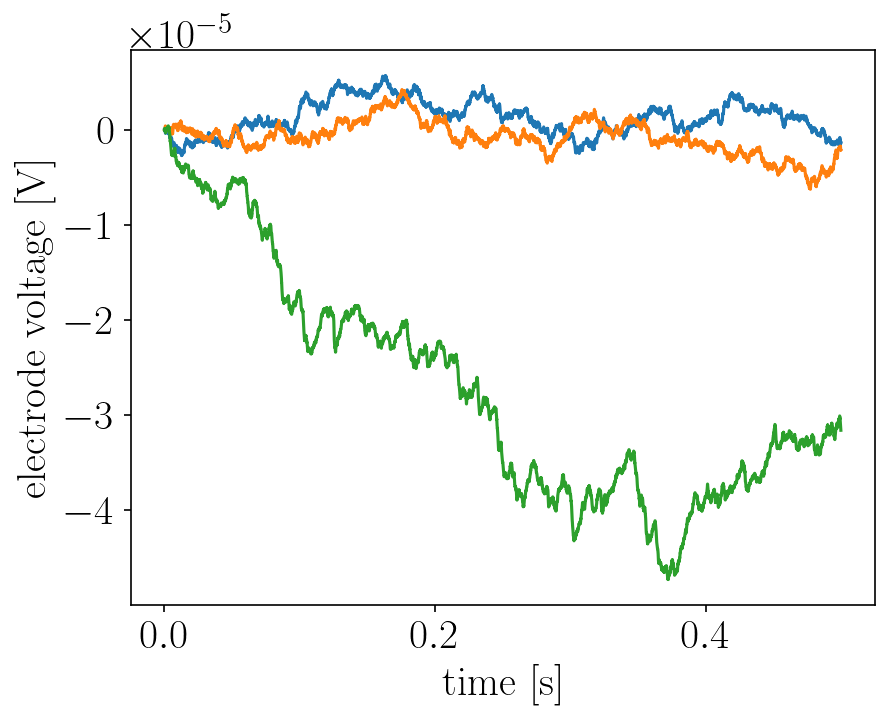

In [42]:
# look at a specific OR
data = odorant_ORN_voltages[:,0]
xrange = np.arange(0, len(data[0])*dt, dt)
for data in data:
    plt.plot(xrange, data)
plt.xlabel('time [s]')
plt.ylabel('electrode voltage [V]')
plt.show()

Plot odorant responses as mean activity

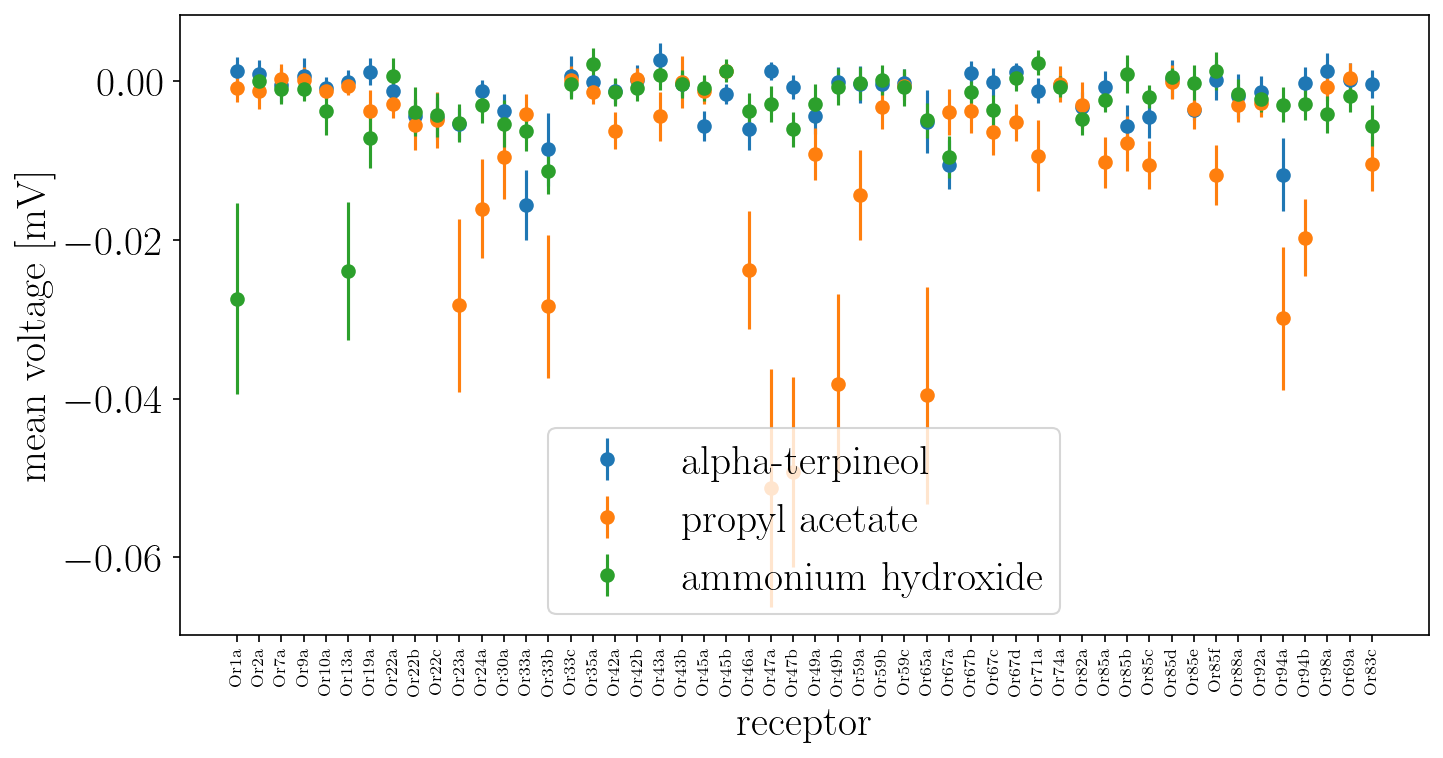

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(2*5.37, 5.37))
plt.rcParams['figure.dpi'] = 300

# scale from V to mV
yscale = 1e+3

for i, odorant_ORN_voltage in enumerate(odorant_ORN_voltages):

    mean = np.mean(odorant_ORN_voltage, axis=1) * yscale
    std = np.std(odorant_ORN_voltage, axis=1) * yscale
    x = np.arange(len(mean))

    plt.errorbar(x, mean, yerr=std, fmt='o', label=selected_odorant_labels[i])
#     plt.bar(x, mean, width=0.5, yerr=std, label="odorant " + str(i))

ax.set(xlabel='receptor', ylabel='mean voltage [mV]')
plt.legend(loc='lower center')
# plt.xlim(1, 25)

# labels = [item.get_text() for item in ax.get_xticklabels()]
# labels = 'Testing'
plt.xticks(np.arange(0, len(receptor_labels)), rotation='vertical', fontsize=8)
ax.set_xticklabels(receptor_labels)

plt.show()